# Compound data acquisition (ChEMBL)

### Contents synopsis
    
**Goal: Get a list of compounds with bioactivity data for a given target**

* Connect to ChEMBL database
* Get target data (example: EGFR kinase)
    * Fetch and download target data
    * Select target ChEMBL ID
* Get bioactivity data
    * Fetch and download bioactivity data for target
    * Preprocess and filter bioactivity data
* Get compound data
    * Fetch and download compound data
    * Preprocess and filter compound data
* Output bioactivity-compound data
    * Merge bioactivity and compound data, and add pIC50 values
    * Draw molecules with highest pIC50
    * Freeze bioactivity data to ChEMBL 27
    * Write output file

#### pIC50 value

* To facilitate the comparison of IC50 values, which have a large value range and are given in different units (M, nM, ...), often pIC50 values are used
* The pIC50 is the negative log of the IC50 value when converted to molar units: 
    $ pIC_{50} = -log_{10}(IC_{50}) $, where $ IC_{50}$ is specified in units of M
* Higher pIC50 values indicate exponentially greater potency of the drug
* Note that the conversion can be adapted to the respective IC50 unit, e.g. for nM: $pIC_{50} = -log_{10}(IC_{50}*10^{-9})= 9-log_{10}(IC_{50}) $

Other activity measures:

Besides, IC50 and pIC50, other bioactivity measures are used, such as the equilibrium constant [KI](https://en.wikipedia.org/wiki/Equilibrium_constant) and the half maximal effective concentration  [EC50](https://en.wikipedia.org/wiki/EC50).

### Connect to ChEMBL database

First, the ChEMBL webresource client is installed, and Python libraries are imported.

In [24]:
!pip install chembl_webresource_client

import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [63]:
HERE = Path(_dh[-1])  #Determine the path we will be working in
DATA = HERE / "data"

Next, we create resource objects for API access.

In [64]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [65]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

### Get target data

* Get UniProt ID of the target of interest (EGFR kinase:  [P00533](http://www.uniprot.org/uniprot/P00533)) from [UniProt website](https://www.uniprot.org/)
* Use UniProt ID to get target information

Select a different UniProt ID, if you are interested in another target.

In [66]:
# Target of interest : Thrombin with UniProt ID: P00734
uniprot_id = "P00734" 

#### Fetch target data from ChEMBL

In [67]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


#### Download target data from ChEMBL

The results of the query are stored in `targets`, a `QuerySet`, i.e. the results are not fetched from ChEMBL until we ask for it (here using `pandas.DataFrame.from_records`).

More information about the `QuerySet` datatype:

> QuerySets are lazy – the act of creating a QuerySet does not involve any database activity. You can stack filters together all day long, and Django will actually not run the query until the QuerySet is evaluated. 
([querysets-are-lazy](https://docs.djangoproject.com/en/3.0/topics/db/queries/#querysets-are-lazy))

In [68]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Thrombin,CHEMBL204,SINGLE PROTEIN
1,Homo sapiens,Thrombin,CHEMBL204,SINGLE PROTEIN
2,Homo sapiens,Thrombin & trypsin,CHEMBL2096988,SELECTIVITY GROUP
3,Homo sapiens,Thrombin and coagulation factor VII,CHEMBL2111477,SELECTIVITY GROUP
4,Homo sapiens,Thrombin and urokinase-type plasminogen activator,CHEMBL2111379,SELECTIVITY GROUP
5,Homo sapiens,Thrombin and coagulation factor X,CHEMBL2111401,SELECTIVITY GROUP


#### Select target (target ChEMBL ID)

After checking the entries, we select the first entry as our target of interest:

`CHEMBL204`: It is a single protein and represents the human protein Thrombin 

In [69]:
# Let's print the first output and validate the basic characteristics
target = targets.iloc[0]
target

organism              Homo sapiens
pref_name                 Thrombin
target_chembl_id         CHEMBL204
target_type         SINGLE PROTEIN
Name: 0, dtype: object

Save selected ChEMBL ID.

In [70]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL204


### Get bioactivity data

Now, we want to query bioactivity data for the target of interest.

#### Fetch bioactivity data for the target from ChEMBL

In this step, we fetch the bioactivity data and filter it to only consider

* human proteins, 
* bioactivity type IC50, 
* exact measurements (relation `'='`), and
* binding data (assay type `'B'`).

In [71]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 1892, <class 'chembl_webresource_client.query_set.QuerySet'>


Each entry in our bioactivity set holds the following information:

In [72]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 32131,
 'assay_chembl_id': 'CHEMBL815798',
 'assay_description': 'In vitro inhibition of human Thrombin (FIIa).',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL117716',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '1270.0',
 'target_chembl_id': 'CHEMBL204',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'nM',
 'value': '1270.0'}

#### Download bioactivity data from ChEMBL

Finally, we download the `QuerySet` in the form of a `pandas` `DataFrame`. 

> **Note**: This step should not take more than 2 minutes, if so try to rerun all cells starting from _"Fetch bioactivity data for the target from ChEMBL"_ or read this message below:

<details>
    
<summary>Load a local version of the data (in case you encounter any problems while fetching the data)</summary>
    
If you experience difficulties to query the ChEMBL database, we also provide the resulting dataframe you will construct in the cell below. If you want to use the saved version, use the following code instead to obtain `bioactivities_df`:
  
```python
# replace first line in cell below with this other line
bioactivities_df = pd.read_csv(DATA / "EGFR_bioactivities_CHEMBL27.csv.zip", index_col=0)
```

</details>

In [73]:
# Inport excel file as .zip and devide file elements by ";" (Note: this depends on the file output CheMBL provides)
bioactivities_df = pd.read_csv(DATA / "CHEMBL204.csv.zip", delimiter = ';')  
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

# If the original bioactivity data file is aquired, filter by column value of prefrance
bioactivities_df = bioactivities_df[bioactivities_df["Standard Type"] == 'IC50'] # Keep only rows for which: Standard Type = 'IC50'

print(f"Units in downloaded data: {bioactivities_df['Standard Type'].unique()}") #To make sure we have IC50 only

bioactivities_df.head()


DataFrame shape: (10620, 45)
Units in downloaded data: ['IC50']


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL273264,NAFAMOSTAT,3,347.38,0,2.65,1 (FUT-175),N=C(N)Nc1ccc(C(=O)Oc2ccc3cc(C(=N)N)ccc3c2)cc1,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1128999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1996.0,None,NaN
6,CHEMBL329908,NaN,0,681.86,1,3.87,ORG-37476,COc1cc(C)c(S(=O)(=O)N[C@@H](CC(=O)OC(C)(C)C)C(...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1131999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1999.0,None,NaN
8,CHEMBL93549,NaN,0,603.75,1,2.03,1d,COc1ccc2ccc(S(=O)(=O)NC(Cc3cc4c(N)nccc4s3)C(=O...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1131999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1999.0,None,NaN
16,CHEMBL179189,NaN,0,522.67,1,3.21,43,CN[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H]...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1142732,1,Scientific Literature,J. Med. Chem.,2005.0,None,NaN
23,CHEMBL432019,NaN,0,663.82,1,2.73,3a,CC(C)(C)OC(=O)NN(Cc1ccccc1)C(=O)[C@@H]1CCCC[C@...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1129829,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1997.0,None,NaN


In [74]:
#Make sure we have the columns we are interested in 
print(bioactivities_df.columns.tolist()) 

# In case we want to drop some of them
#bioactivities_df.drop(["units", "value"], axis=1, inplace=True)  ##WE DO NOT HAVE THESE COLUMNS
#bioactivities_df.head()

['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase', 'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment', 'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE', 'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate', 'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID', 'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID', 'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction', 'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation', 'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type', 'Document ChEMBL ID', 'Source ID', 'Source Description', 'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties']


#### Preprocess and filter bioactivity data

1. Convert `Standard Value`'s datatype from `object` to `float`
2. Delete entries with missing values
3. Keep only entries with `Standard Unit == nM`
4. Delete duplicate molecules
5. Reset `DataFrame` index
6. Rename columns

**1. Convert datatype of "standard_value" from "object" to "float"**

The field `Standard Value` holds standardized (here IC50) values. In order to make these values usable in calculations later on, convert values to floats.

In [75]:
bioactivities_df.dtypes

Molecule ChEMBL ID             object
Molecule Name                  object
Molecule Max Phase              int64
Molecular Weight              float64
#RO5 Violations                object
AlogP                          object
Compound Key                   object
Smiles                         object
Standard Type                  object
Standard Relation              object
Standard Value                float64
Standard Units                 object
pChEMBL Value                 float64
Data Validity Comment          object
Comment                        object
Uo Units                       object
Ligand Efficiency BEI         float64
Ligand Efficiency LE           object
Ligand Efficiency LLE          object
Ligand Efficiency SEI          object
Potential Duplicate             int64
Assay ChEMBL ID                object
Assay Description              object
Assay Type                     object
BAO Format ID                  object
BAO Label                      object
Assay Organi

In [76]:
# In case we want to change the values' type
#bioactivities_df = bioactivities_df.astype({"Standard Value": "float64"})  ##FROM WHAT WE SEE IT WAS ALREADY FLOAT!
#bioactivities_df.dtypes

**2. Delete entries with missing values**

Use the parameter `inplace=True` to drop values in the current `DataFrame` directly.

In [80]:
## CAUTION! ## IF you call WHOLE df.dropna it will most likely drop every row. NA found at some column in each compound! ##

bioactivities_df["Standard Value"].dropna(axis=0, how="any", inplace=True) 
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df

DataFrame shape: (3384, 45)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL273264,NAFAMOSTAT,3,347.38,0,2.65,1 (FUT-175),N=C(N)Nc1ccc(C(=O)Oc2ccc3cc(C(=N)N)ccc3c2)cc1,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1128999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1996.0,None,NaN
6,CHEMBL329908,NaN,0,681.86,1,3.87,ORG-37476,COc1cc(C)c(S(=O)(=O)N[C@@H](CC(=O)OC(C)(C)C)C(...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1131999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1999.0,None,NaN
8,CHEMBL93549,NaN,0,603.75,1,2.03,1d,COc1ccc2ccc(S(=O)(=O)NC(Cc3cc4c(N)nccc4s3)C(=O...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1131999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1999.0,None,NaN
16,CHEMBL179189,NaN,0,522.67,1,3.21,43,CN[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H]...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1142732,1,Scientific Literature,J. Med. Chem.,2005.0,None,NaN
23,CHEMBL432019,NaN,0,663.82,1,2.73,3a,CC(C)(C)OC(=O)NN(Cc1ccccc1)C(=O)[C@@H]1CCCC[C@...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1129829,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1997.0,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10567,CHEMBL221542,BETA-SITOSTEROL,0,414.72,1,8.02,BSS,CC[C@H](CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL4266047,1,Scientific Literature,J Nat Prod,2018.0,None,NaN
10573,CHEMBL3965746,NaN,0,647.16,1,2.94,BDBM238254,O=C(Nc1ccccc1)[C@@H]1C[C@H](N2CCN(S(=O)(=O)c3c...,IC50,'>',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL3886831,37,BindingDB Database,NaN,2016.0,None,NaN
10576,CHEMBL48361,DABIGATRAN,3,471.52,0,2.99,1,Cn1c(CNc2ccc(C(=N)N)cc2)nc2cc(C(=O)N(CCC(=O)O)...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL4673255,1,Scientific Literature,J Med Chem,2020.0,None,TIME = 1.0 hr
10579,CHEMBL4441232,NaN,0,542.68,1,3.92,8,COc1cc(C(=O)N2C[C@@H](n3cc(C4CC4)nn3)C[C@H]2C(...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL4425182,1,Scientific Literature,Bioorg Med Chem Lett,2016.0,None,NaN


**3. Keep only entries with "standard_unit == nM"** 

We only want to keep bioactivity entries in `nM`, thus we remove all entries with other units.

In [81]:
print(f"Units in downloaded data: {bioactivities_df['Standard Units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['Standard Units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM' 'ug.mL-1' nan]
Number of non-nM entries:    115


In [82]:
bioactivities_df = bioactivities_df[bioactivities_df["Standard Units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['Standard Units'].unique()}")

Units after filtering: ['nM']


In [83]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3269, 45)


**4. Delete duplicate molecules**

Sometimes the same molecule (`Molecule ChEMBL ID`) has been tested more than once, in this case, we only keep the first one.

Note other choices could be to keep the one with the best value or a mean value of all assay results for the respective compound.

In [84]:
bioactivities_df.drop_duplicates("Molecule ChEMBL ID", keep="first", inplace=True)  ##WORKS THE SAME WITH SMILES COLUMN
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3003, 45)


/tmp/ipykernel_130/252920599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bioactivities_df.drop_duplicates("Molecule ChEMBL ID", keep="first", inplace=True)  ##WORKS THE SAME WITH SMILES COLUMN


**5. Reset "DataFrame" index**

Since we deleted some rows, but we want to iterate over the index later, we reset the index to be continuous.

In [85]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL273264,NAFAMOSTAT,3,347.38,0,2.65,1 (FUT-175),N=C(N)Nc1ccc(C(=O)Oc2ccc3cc(C(=N)N)ccc3c2)cc1,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1128999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1996.0,None,NaN
1,CHEMBL329908,NaN,0,681.86,1,3.87,ORG-37476,COc1cc(C)c(S(=O)(=O)N[C@@H](CC(=O)OC(C)(C)C)C(...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1131999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1999.0,None,NaN
2,CHEMBL93549,NaN,0,603.75,1,2.03,1d,COc1ccc2ccc(S(=O)(=O)NC(Cc3cc4c(N)nccc4s3)C(=O...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1131999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1999.0,None,NaN
3,CHEMBL179189,NaN,0,522.67,1,3.21,43,CN[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H]...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1142732,1,Scientific Literature,J. Med. Chem.,2005.0,None,NaN
4,CHEMBL432019,NaN,0,663.82,1,2.73,3a,CC(C)(C)OC(=O)NN(Cc1ccccc1)C(=O)[C@@H]1CCCC[C@...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1129829,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1997.0,None,NaN


**6. Rename columns**

In [86]:
bioactivities_df.rename(
    columns={"Molecule ChEMBL ID": "molecule_chembl_id", "Standard Value": "IC50", "Standard Units": "units"}, inplace=True
)
bioactivities_df.head()

/tmp/ipykernel_130/1519758301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bioactivities_df.rename(


,molecule_chembl_id,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL273264,NAFAMOSTAT,3,347.38,0,2.65,1 (FUT-175),N=C(N)Nc1ccc(C(=O)Oc2ccc3cc(C(=N)N)ccc3c2)cc1,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1128999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1996.0,None,NaN
1,CHEMBL329908,NaN,0,681.86,1,3.87,ORG-37476,COc1cc(C)c(S(=O)(=O)N[C@@H](CC(=O)OC(C)(C)C)C(...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1131999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1999.0,None,NaN
2,CHEMBL93549,NaN,0,603.75,1,2.03,1d,COc1ccc2ccc(S(=O)(=O)NC(Cc3cc4c(N)nccc4s3)C(=O...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1131999,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1999.0,None,NaN
3,CHEMBL179189,NaN,0,522.67,1,3.21,43,CN[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H]...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1142732,1,Scientific Literature,J. Med. Chem.,2005.0,None,NaN
4,CHEMBL432019,NaN,0,663.82,1,2.73,3a,CC(C)(C)OC(=O)NN(Cc1ccccc1)C(=O)[C@@H]1CCCC[C@...,IC50,'=',...,Thrombin,Homo sapiens,SINGLE PROTEIN,CHEMBL1129829,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1997.0,None,NaN


In [87]:
bioactivities_df.dtypes

molecule_chembl_id             object
Molecule Name                  object
Molecule Max Phase              int64
Molecular Weight              float64
#RO5 Violations                object
AlogP                          object
Compound Key                   object
Smiles                         object
Standard Type                  object
Standard Relation              object
IC50                          float64
units                          object
pChEMBL Value                 float64
Data Validity Comment          object
Comment                        object
Uo Units                       object
Ligand Efficiency BEI         float64
Ligand Efficiency LE           object
Ligand Efficiency LLE          object
Ligand Efficiency SEI          object
Potential Duplicate             int64
Assay ChEMBL ID                object
Assay Description              object
Assay Type                     object
BAO Format ID                  object
BAO Label                      object
Assay Organi

In [88]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3003, 45)


We now have a set of **3003** molecule ids with respective IC50 values for our target kinase.

### Get compound data

We have a `DataFrame` containing all molecules tested against Thrombin (with the respective measured bioactivity). 

Now, we want to get the molecular structures of the molecules that are linked to respective bioactivity ChEMBL IDs. 

#### Fetch compound data from ChEMBL

Let's have a look at the compounds from ChEMBL which we have defined bioactivity data for: We fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [89]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

#### Download compound data from ChEMBL

Again, we want to export the `QuerySet` object into a `pandas.DataFrame`. Given the data volume, **this can take some time.** For that reason, we will first obtain the list of records through `tqdm`, so we get a nice progress bar and some ETAs. We can then pass the list of compounds to the DataFrame.

In [90]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/3003 [00:00<?, ?it/s]

In [91]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3003, 2)


In [92]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL266349,{'canonical_smiles': 'N=C(N)c1ccc(CNC(=O)[C@@H...
1,CHEMBL268328,{'canonical_smiles': 'COc1ccc(C[C@H](NC(=O)Nc2...
2,CHEMBL428311,{'canonical_smiles': 'N=C(N)NCCC[C@H](NC(=O)[C...
3,CHEMBL275003,{'canonical_smiles': 'NC(CCN[C@H](NC(=O)[C@H](...
4,CHEMBL7627,{'canonical_smiles': 'COc1ccc(C[C@H](NC(=O)Nc2...


#### Preprocess and filter compound data

1. Remove entries with missing entries
2. Delete duplicate molecules (by molecule_chembl_id)
3. Get molecules with canonical SMILES

**1. Remove entries with missing molecule structure entry**

In [93]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3003, 2)


**2. Delete duplicate molecules**

In [94]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3003, 2)


**3. Get molecules with canonical SMILES**

So far, we have multiple different molecular structure representations. We only want to keep the canonical SMILES.

In [95]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [96]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3003, 2)


In [97]:
compounds_df

,molecule_chembl_id,smiles
0,CHEMBL266349,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...
1,CHEMBL268328,COc1ccc(C[C@H](NC(=O)Nc2ccc3c(CN4CCCC4)cn(Cc4c...
2,CHEMBL428311,N=C(N)NCCC[C@H](NC(=O)[C@H](Cc1ccc(F)c(F)c1)NC...
3,CHEMBL275003,NC(CCN[C@H](NC(=O)[C@H](Cc1ccc(F)c(F)c1)NC(=O)...
4,CHEMBL7627,COc1ccc(C[C@H](NC(=O)Nc2ccc3c(CNC4CCCC4)cn(Cc4...
...,...,...
2998,CHEMBL4786773,COc1ccc(C(=O)n2nc(-c3ccccn3)nc2N)cc1
2999,CHEMBL4791078,Cc1ccc(S(=O)(=O)Nc2nc(-c3ccncc3)n[nH]2)cc1
3000,CHEMBL4797183,O=C(Nc1nc(-c2cccnc2)n[nH]1)c1ccccc1
3001,CHEMBL4800151,Nc1nc(-c2ccccn2)nn1C(=O)c1ccc([N+](=O)[O-])cc1


Sanity check: Remove all molecules without a canonical SMILES string.

In [98]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3003, 2)


### Output (bioactivity-compound) data
**Summary of compound and bioactivity data**

In [99]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 3003


Index(['molecule_chembl_id', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'IC50', 'units',
       'pChEMBL Value', 'Data Validity Comment', 'Comment', 'Uo Units',
       'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')

In [100]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 3003


Index(['molecule_chembl_id', 'smiles'], dtype='object')

#### Merge both datasets

Merge values of interest from `bioactivities_df` and `compounds_df` in an `output_df` based on the compounds' ChEMBL IDs (`molecule_chembl_id`), keeping the following columns:

* ChEMBL IDs: `molecule_chembl_id`
* SMILES: `smiles`
* units: `units`
* IC50: `IC50`

In [101]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 3003 entries.


In [102]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [103]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL273264,290.0,nM,N=C(N)Nc1ccc(C(=O)Oc2ccc3cc(C(=N)N)ccc3c2)cc1
1,CHEMBL329908,80.0,nM,COc1cc(C)c(S(=O)(=O)N[C@@H](CC(=O)OC(C)(C)C)C(...
2,CHEMBL93549,560.0,nM,COc1ccc2ccc(S(=O)(=O)NC(Cc3cc4c(N)nccc4s3)C(=O...
3,CHEMBL179189,46000.0,nM,CN[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H]...
4,CHEMBL432019,880.0,nM,CC(C)(C)OC(=O)NN(Cc1ccccc1)C(=O)[C@@H]1CCCC[C@...
5,CHEMBL384263,34000.0,nM,Cc1cccc(C(=O)N[C@H](CO)C(=O)N[C@@H](C)C(=O)NC(...
6,CHEMBL104472,45.0,nM,CC(C)(C)OC(=O)N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]...
7,CHEMBL317856,94.0,nM,C[C@@H](C(=O)N1CCC[C@H]1C(=O)N[C@H](C=O)CCCN=C...
8,CHEMBL366894,11000.0,nM,NC(=O)C1CCN(Cc2ccc(C(=O)Nc3ccc(Cl)cc3C(=O)Nc3c...
9,CHEMBL345763,10000.0,nM,CC(=N)N1CCC(Oc2ccc(N(Cc3cc(-c4cccc(C(=N)N)c4)n...


#### Add pIC50 values

As you can see the low IC50 values are difficult to read (values are distributed over multiple scales), which is why we convert the IC50 values to pIC50.

In [104]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [105]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [106]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL273264,290.0,nM,N=C(N)Nc1ccc(C(=O)Oc2ccc3cc(C(=N)N)ccc3c2)cc1,6.537602
1,CHEMBL329908,80.0,nM,COc1cc(C)c(S(=O)(=O)N[C@@H](CC(=O)OC(C)(C)C)C(...,7.096910
2,CHEMBL93549,560.0,nM,COc1ccc2ccc(S(=O)(=O)NC(Cc3cc4c(N)nccc4s3)C(=O...,6.251812
3,CHEMBL179189,46000.0,nM,CN[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H]...,4.337242
4,CHEMBL432019,880.0,nM,CC(C)(C)OC(=O)NN(Cc1ccccc1)C(=O)[C@@H]1CCCC[C@...,6.055517


#### Draw compound data

Let's have a look at our collected data set.

First, we plot the pIC50 value distribution

array([[<AxesSubplot:title={'center':'pIC50'}>]], dtype=object)

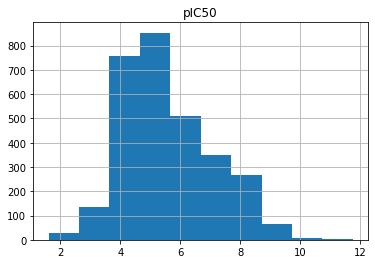

In [107]:
output_df.hist(column="pIC50")

In the next steps, we add a column for RDKit molecule objects to our `DataFrame` and look at the structures of the molecules with the highest pIC50 values. 

In [108]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [109]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

Show the three most active molecules, i.e. molecules with the highest pIC50 values.

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL275366,0.0017,nM,11.769551,
1,CHEMBL105819,0.0080,nM,11.096910,
2,CHEMBL4108739,0.0100,nM,11.000000,

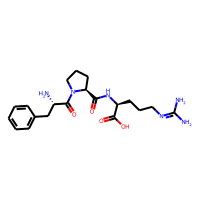
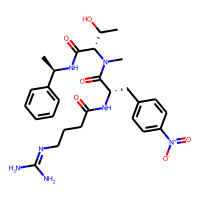
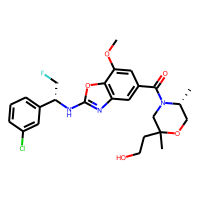

In [110]:
output_df.drop("smiles", axis=1).head(3)

In [111]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (3003, 5)


#### Freeze output data to ChEMBL 27

This is a technical step: Usually, we would continue to work with the dataset that we just created (latest dataset). 

However, here on the TeachOpenCADD platform, we prefer to freeze the dataset to a certain ChEMBL releases (i.e. [ChEMBL 27](http://doi.org/10.6019/CHEMBL.database.27)), 
so that this talktorial and other talktorials downstream in our CADD pipeline do not change in the future (helping us to maintain the talktorials).

<div class="alert alert-block alert-info">

<b>Note:</b> If you prefer to run this notebook on the latest dataset or if you want to use it for another target, please comment the cell below.

</div>

In [112]:
# Disable this cell to unfreeze the dataset
#output_df = pd.read_csv(
#    DATA / "Thrombin_compounds.csv", index_col=0, float_precision="round_trip"
#)
#output_df.head()

In [113]:
print(f"DataFrame shape: {output_df.shape}")
# NBVAL_CHECK_OUTPUT

DataFrame shape: (3003, 5)


#### Write output data to file: Thrombin_compounds

We want to use this bioactivity-compound dataset in the following talktorials, thus we save the data as `csv` file. 
Note that it is advisable to drop the molecule column (which only contains an image of the molecules) when saving the data.

In [114]:
output_df.to_csv(DATA / "Thrombin_compounds.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL275366,0.0017,nM,NC(N)=NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,11.769551
1,CHEMBL105819,0.0080,nM,CC(O)[C@@H](C(=O)N[C@H](C)c1ccccc1)N(C)C(=O)[C...,11.096910
2,CHEMBL4108739,0.0100,nM,COc1cc(C(=O)N2CC(C)(CCO)OC[C@H]2C)cc2nc(N[C@@H...,11.000000
3,CHEMBL143418,0.0420,nM,Cc1nc(N)ccc1CNC(=O)Cn1c(C)cnc(NCC(F)(F)c2ccccn...,10.376751
4,CHEMBL4111930,0.1000,nM,COc1cc(C(=O)N2CC(C)(CC(C)O)OC[C@H]2C)cc2nc(NC(...,10.000000


In [115]:
print(f"DataFrame shape: {output_df.shape}")
# NBVAL_CHECK_OUTPUT

DataFrame shape: (3003, 5)


## Discussion

By performing this procedure, we collected bioactivity data for our target of interest from the ChEMBL database. 
We filtered the data set in order to only contain molecules with measured IC50 bioactivity values. 

Be aware that ChEMBL data originates from various sources. Compound data has been generated in different labs by different people all over the world. Therefore, we have to be cautious with the predictions we make using this data set. It is always important to consider the source of the data and consistency of data production assays when interpreting the results and determining how much confidence we have in our predictions.

Nonetheless, we see the top scored screened compounds based on the pIC50 that we will investigate more in order to propose new molecules and try to explain the more robust inhibition in the binding site based on ligand interactions inside the protein binding site.
